# 2. Mean-Variance Optimization
### 1. Summary Statistics
- Calculate and display the mean and volatility of each asset’s excess return. (Recall we use volatility to refer to standard deviation.)
- Which assets have the best and worst Sharpe ratios?

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [65]:
priceData = pd.read_excel("../../data/multi_asset_etf_data.xlsx", sheet_name = "prices").set_index("Date")
totalReturnData = pd.read_excel("../../data/multi_asset_etf_data.xlsx", sheet_name = "total returns").set_index("Date")
excessReturnData = pd.read_excel("../../data/multi_asset_etf_data.xlsx", sheet_name = "excess returns").set_index("Date")

In [75]:
mean, vol = list(), list()

for ticker in excessReturnData.columns:
    mean.append(excessReturnData[ticker].mean() * 12)
    vol.append(excessReturnData[ticker].std() * np.sqrt(12))

sharpe = [m / v for m, v in zip(mean, vol)]
result = pd.DataFrame({'Ticker': excessReturnData.columns, 'Mean': mean, 'Volatility': vol, 'Sharpe': sharpe})
print(result)

   Ticker      Mean  Volatility    Sharpe
0     BWX -0.007716    0.082789 -0.093202
1     DBC -0.005292    0.166553 -0.031774
2     EEM  0.029339    0.176164  0.166542
3     EFA  0.061775    0.150903  0.409372
4     HYG  0.041371    0.075928  0.544873
5     IEF  0.016404    0.063442  0.258569
6     IYR  0.074916    0.168675  0.444143
7     PSP  0.092561    0.213370  0.433804
8     QAI  0.019327    0.049073  0.393838
9     SPY  0.128141    0.142839  0.897103
10    TIP  0.020502    0.051115  0.401091


- SPY has the highest sharpe ratio of 0.897
- BWX has the worst sharpe ratio of -0.093

---

### 2. Descriptive Analysis
- Calculate the correlation matrix of the returns. Which pair has the highest correlation? And the lowest?
- How well have TIPS done in our sample? Have they outperformed domestic bonds? Foreign bonds?

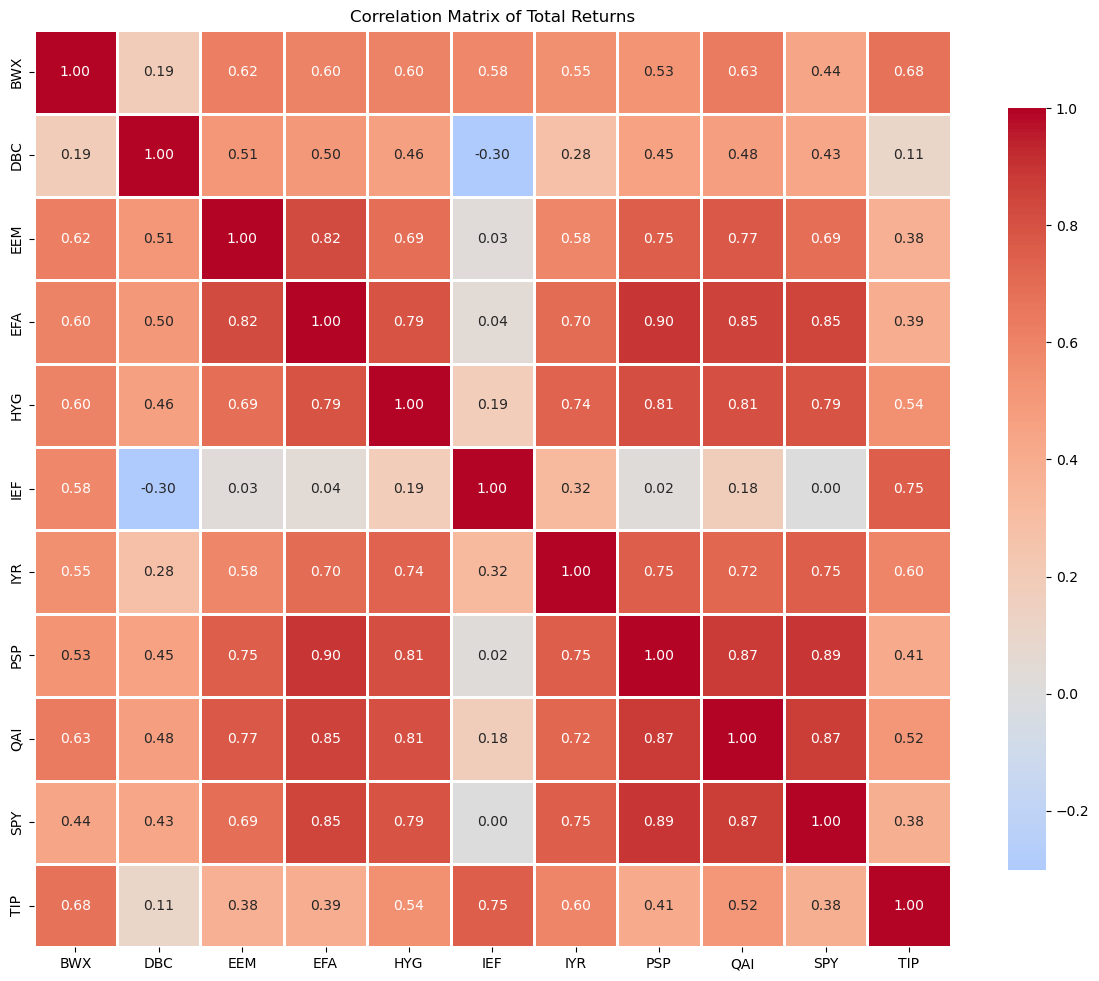

In [67]:
corr_matrix = excessReturnData.corr()

plt.figure(figsize = (12, 10))
sns.heatmap(corr_matrix, annot = True, fmt = '.2f', cmap = 'coolwarm', center = 0, 
            square = True, linewidths = 1, cbar_kws = {"shrink": 0.8})
plt.title('Correlation Matrix of Total Returns')
plt.tight_layout()
plt.show()

- Lowest correlation pairs
  - (SPY, IEF) with correlation of 0.00
  - (PSP, IEF) with correlation of 0.02
- Highest correlation pairs
  - (PSP, EFA) with correlation of 0.90
  - (PSP, SPY) with correlation of 0.89

TIPS has a high Sharpe ratio of 0.4. Its average excess return is 2.05%, which is higher than domestic bonds (1.64%) and foreign bonds (-0.77%). It has low return, but accompanied with low volatility of 5.11%. Overall, TIPS has done well in our sample.

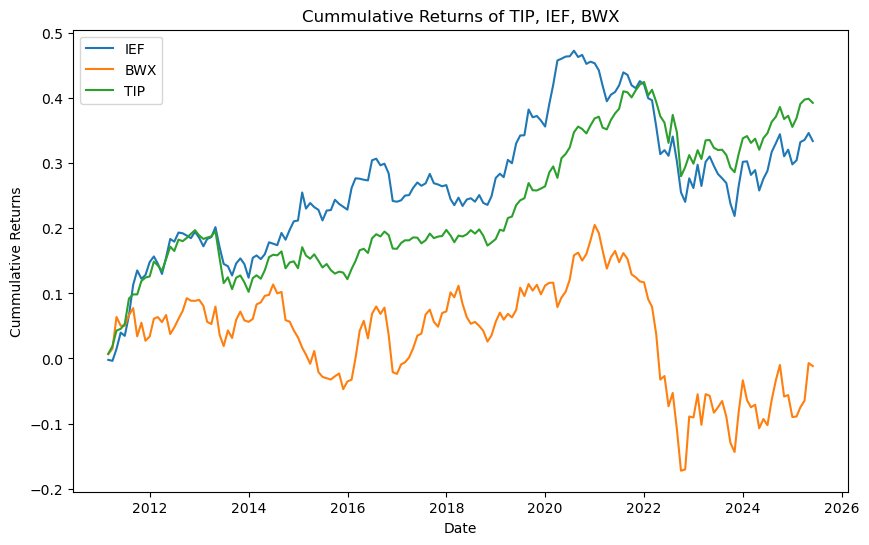

In [68]:
IEFreturn, BWXreturn, TIPreturn = [0], [0], [0]

for ief, bwx, tip in zip(totalReturnData['IEF'], totalReturnData['BWX'], totalReturnData['TIP']):
    IEFreturn.append(ief + IEFreturn[-1])
    BWXreturn.append(bwx + BWXreturn[-1])
    TIPreturn.append(tip + TIPreturn[-1])
    
plt.figure(figsize = (10, 6))
plt.plot(totalReturnData.index, IEFreturn[1:], label = 'IEF')
plt.plot(totalReturnData.index, BWXreturn[1:], label = 'BWX')
plt.plot(totalReturnData.index, TIPreturn[1:], label = 'TIP')
plt.title('Cummulative Returns of TIP, IEF, BWX')
plt.ylabel('Cummulative Returns')
plt.xlabel('Date')
plt.legend()
plt.show()

---

### 3. The MV frontier.
- Compute and display the weights of the tangency portfolios: $$w_{tan} = \delta_{tan}\Sigma^{-1}\~\mu$$

- Does the ranking of weights align with the ranking of Sharpe ratios?
- Compute the mean, volatility, and Sharpe ratio for the tangency portfolio corresponding to $w_{tan}$.

In [78]:
# Calculate Tangency Weights

def CalcTangencyWeights(returns):
    covMat = returns.cov() * 12 # covariance matrix * annual factor
    covInv = np.linalg.inv(covMat) # Sigma^(-1)
    mu = returns.mean() * 12    # mean return vector * auunal factor
    scaling = 1 / (np.transpose(np.ones(len(returns.columns))) @ covInv @ mu)
    tangencyWeights = scaling * (covInv @ mu)
    return tangencyWeights

weights = CalcTangencyWeights(excessReturnData)
tangencyWeights = pd.DataFrame({
    "Asset": excessReturnData.columns,
    "Sharpe": result["Sharpe"],
    "Weights": weights
})
print(tangencyWeights.sort_values(by = "Sharpe", ascending = False))
print("\nSum of weights:", tangencyWeights['Weights'].sum())

   Asset    Sharpe    Weights
9    SPY  0.897103  10.729782
4    HYG  0.544873   2.634922
6    IYR  0.444143  -2.382146
7    PSP  0.433804  -1.716842
3    EFA  0.409372   0.385285
10   TIP  0.401091   1.330595
8    QAI  0.393838 -13.616007
5    IEF  0.258569   9.010591
2    EEM  0.166542   0.853591
1    DBC -0.031774  -0.112341
0    BWX -0.093202  -6.117430

Sum of weights: 1.0000000000000036


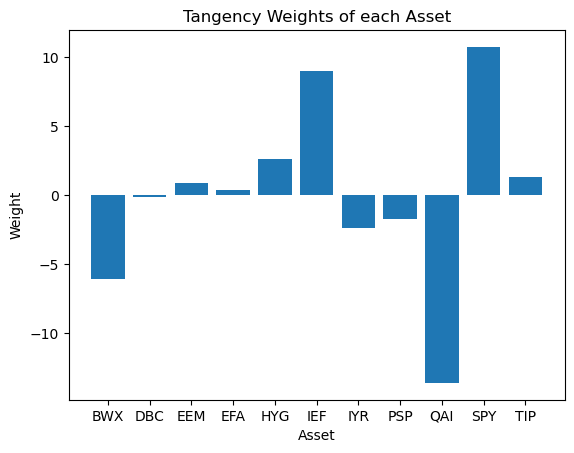

In [86]:
def TangencyWeightsPlot(weights):
    plt.bar(x = weights["Asset"], height = weights["Weights"])
    plt.title("Tangency Weights of each Asset")
    plt.ylabel("Weight")
    plt.xlabel("Asset")
    plt.show()
    
TangencyWeightsPlot(tangencyWeights)

In [93]:
def CalcTangencyPortfolio(returns, portfolioWeights):
    portfolioReturn = returns @ portfolioWeights
    meanReturn = portfolioReturn.mean() * 12
    stdReturn = portfolioReturn.std() * np.sqrt(12)
    portfolioSharpe = meanReturn / stdReturn
    tangencyResult = pd.DataFrame({
        "Portfolio Mean": [meanReturn],
        "Portfolio STD": [stdReturn],
        "Portfolio Sharpe": [portfolioSharpe]
    })
    return tangencyResult

tangencyResult = CalcTangencyPortfolio(excessReturnData, weights)
print(tangencyResult)

   Portfolio Mean  Portfolio STD  Portfolio Sharpe
0        1.155145       0.744433           1.55171


---

### 4. TIPS
Assess how much the tangency portfolio (and performance) change if…

- TIPS are dropped completely from the investment set.

- The expected excess return to TIPS is adjusted to be 0.0012 higher than what the historic sample shows.

Based on the analysis, do TIPS seem to expand the investment opportunity set, implying that Harvard should consider them as a separate asset?

In [85]:
excessReturnWithoutTIP = excessReturnData.drop(columns = ["TIP"])
weightsWithoutTIP = CalcTangencyWeights(excessReturnWithoutTIP)
tangencyWeightsWithoutTIP = pd.DataFrame({
    "Asset": excessReturnWithoutTIP.columns,
    "Weights": weightsWithoutTIP
})
print(tangencyWeightsWithoutTIP)
print("\nSum of weights:", tangencyWeightsWithoutTIP['Weights'].sum())

  Asset    Weights
0   BWX  -8.320309
1   DBC  -0.048440
2   EEM   1.215107
3   EFA   0.415306
4   HYG   3.744656
5   IEF  13.355289
6   IYR  -3.167946
7   PSP  -2.284411
8   QAI -18.571185
9   SPY  14.661934

Sum of weights: 0.9999999999999947


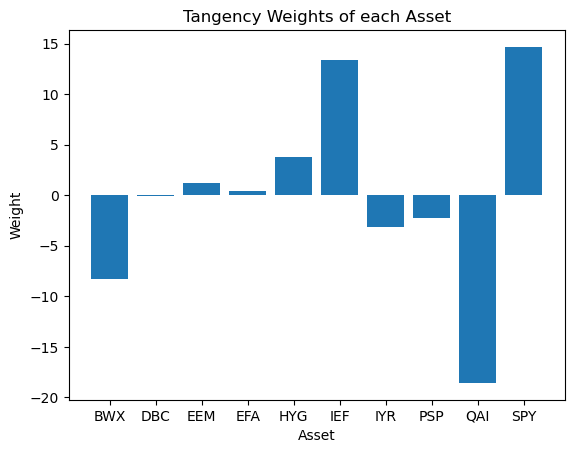

In [87]:
TangencyWeightsPlot(tangencyWeightsWithoutTIP)

In [95]:
tangencyResultWithoutTIP = CalcTangencyPortfolio(excessReturnWithoutTIP, weightsWithoutTIP)
print("W/ TIPS")
print(tangencyResult)
print("")
print("W/O TIPS")
print(tangencyResultWithoutTIP)

W/ TIPS
   Portfolio Mean  Portfolio STD  Portfolio Sharpe
0        1.155145       0.744433           1.55171

W/O TIPS
   Portfolio Mean  Portfolio STD  Portfolio Sharpe
0        1.570867       1.013288          1.550267


Without TIPS:
- Higher Mean
- Higher STD
- Lower Sharpe Ratio